In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import json
import scipy.stats as st

from multiprocessing import Pool, cpu_count


### Objective
* Clean and explore the data provided
* Produce a method for identifying unusual correlation coefficients within transformer pairings

### Background/Research Data
It has already been determined that correlation coefficients are helpful for spotting mislabeled transformer/customer pairs [1]. In the table below, `T1-M5` is known to be a mislabeled pair, while the other four pairs are correctly paired. The correlations are for in-ground cables, assumed to be the highest correlations that the grid is likely to see. 

|       | T1-M1 | T1-M2  | T1-M3   | T1-M4 | T1-M5   |
|-------|-------|---|---|---|---|
| T1-M1 | 1.0   |   |   |   |   |
| T1-M2 | 0.97936  | 1.0  |   |   |   |
| T1-M3 | 0.98014  | 0.98239   |1.0   |   |   |
| T1-M4 | 0.97966  | 0.98127  | 0.97980  |  1.0 |   |
| T1-M5 | 0.94359  | 0.94901  | 0.94768  |  0.94893 |  1.0 |

*Source: Transformer_Corr_Function.xlsx Sheet1

In [2]:
# Encode the correlations from the first data set
test_corrs = [0.97936, 0.98014, 0.97966, 0.94359, 0.98239, 0.98127, 0.94901, 0.97980, 0.94768, 0.94893]

In [3]:
# We do want some sense of the shape of our data, and its center
test_mean = np.mean(test_corrs)

In [4]:
test_std = np.std(test_corrs)

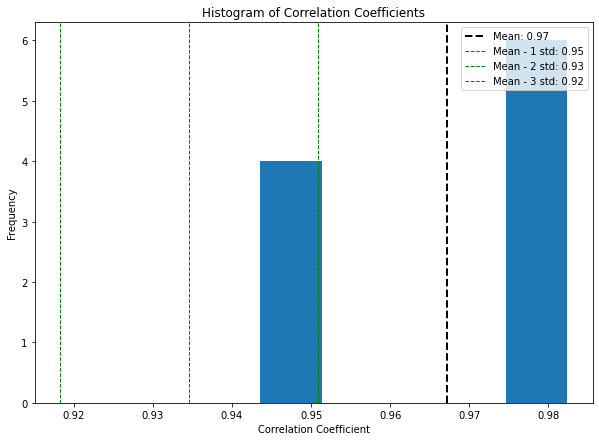

In [5]:
mafig, ax = plt.subplots(figsize =(10, 7))
ax.hist(test_corrs, bins='auto')
plt.axvline(test_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {test_mean:.2f}')


for i in range(1, 4):
    dev = i * test_std
    plt.axvline(test_mean - dev, color='green', linestyle='dashed', linewidth=1, 
                label=f'Mean - {i} std: {test_mean - dev:.2f}')

plt.title('Histogram of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

# Add legend
plt.legend()
    
# Show plot
plt.show()

Because this sample data is so small, we can eyeball the chart. The four lowest corrrelation coefficients are all associated with `T1-M5`. 

((array([-1.49876728, -0.98494667, -0.64703803, -0.37109819, -0.12121409,
          0.12121409,  0.37109819,  0.64703803,  0.98494667,  1.49876728]),
  array([0.94359, 0.94768, 0.94893, 0.94901, 0.97936, 0.97966, 0.9798 ,
         0.98014, 0.98127, 0.98239])),
 (0.016223557148013025, 0.9671830000000001, 0.865569641049545))

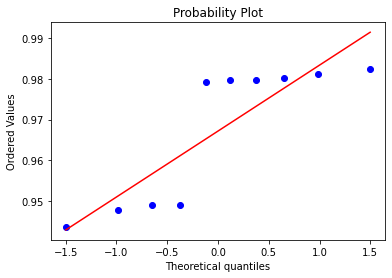

In [6]:
# A probability plot shows us whether a sample is likely drawn from a normal distribution.
# We want to see a mostly straight line.
stats.probplot(test_corrs, plot=plt)

The small (probably too small) sample of correlation coefficients do not indicate normality on this test. We would epxect to see an approximately straight line if the data were shown to be normal. This is included here to indicate that some caution around using typical statistical tools may be warranted.

In [7]:
st.normaltest(test_corrs)

/Users/charlesrice/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=7.0477607899594235, pvalue=0.0294848002265323)

The function tests the hypothesis that the distribution passed into the function differs from the normal distribution. The null hypothesis would then be that the data is normally distributed. We typically reject the null hypothesis if the p-value is less than 0.05.

### The Data
We know what method we're going to use, but it's still helpful to go through a full exploratory process. It's good practice, and helps us commune with the data.

In [9]:
# Read in the data, assigned to dataframe apc
apc = pd.read_parquet('./data/Flat_Iron_Dataset_06292023.parquet')

In [ ]:
#!pip install pyarrow

In [8]:
# How large is it?
apc.shape

(81907542, 5)

In [10]:
# What columns do we have? What do they represent?
apc.columns

Index(['endpoint_id', 'sample_date', 'sample_point', 'voltage', 'fldptag'], dtype='object')

In [11]:
apc.dtypes

endpoint_id       int64
sample_date      object
sample_point      int64
voltage         float64
fldptag          object
dtype: object

#### Data Dictionary

81m rows; five columns:  

| Name  | Type  |  Description |    
|  ---  | ---   |  ---  |
| endpoint_id  |  int64 | customer id  |    
| sample_date  | object  | date sample was taken  | 
| sample_point  | int64  | ??  |  
| voltage  | float |  voltage reading at sample_date | 
| fldptag  |  object |  transformer id | 

`Sample_point`'s purpose is unclear, and `sample_date` isn't a timestamp or datetime object. Also, of `endpoint_id` and `fldtptag`, which represents the customer and which the transformer?

#### Fixing `sample_date`
We do know that we are going to be working with timeseries, so we want to get our timestampe column into a datetime opject.

In [12]:
# Overwrite `sample_date` with the datetime object
apc['sample_date'] = pd.to_datetime(apc['sample_date'])

In [13]:
# Check that it worked
apc.dtypes

endpoint_id              int64
sample_date     datetime64[ns]
sample_point             int64
voltage                float64
fldptag                 object
dtype: object

#### What is `sample_point`?
Not knowing what it is, this seems like as good a time as any for basic variable exploration. See what we've got, and how many.

In [14]:
# No nulls in the original df
for i in apc.columns:
    print(f"Nulls in {i}:", apc[i].isna().sum())

Nulls in endpoint_id: 0
Nulls in sample_date: 0
Nulls in sample_point: 0
Nulls in voltage: 0
Nulls in fldptag: 0


In [15]:
# Check unique values
for i in apc.columns:
    print(f"Unique values in {i}: ", apc[i].nunique())

Unique values in endpoint_id:  20029
Unique values in sample_date:  5548
Unique values in sample_point:  5548
Unique values in voltage:  5229
Unique values in fldptag:  8079


`Sample_date` and `sample_point` have the same number of unique values.

In [16]:
apc[apc['sample_point']==1682918100].sample_date.nunique()

1

In [17]:
s_points = apc.groupby('sample_point')['sample_date'].nunique()

In [17]:
sum(s_points)

5548

So `sample_point` appears to be a unique identifier for the timestamp in `sample_date`.

#### Variables: `fldptag` or `endpoint_id`
Which represents the transformer, which represents the customer?

In [18]:
# Check unique values, again
for i in apc.columns:
    print(f"Unique values in {i}: ", apc[i].nunique())

Unique values in endpoint_id:  20029
Unique values in sample_date:  5548
Unique values in sample_point:  5548
Unique values in voltage:  5229
Unique values in fldptag:  8079


There's more unique `endpoint_id`s than there are `fldptag`, so presumably `fldptag` represents the transformer and the `endpoint_id` represents the customer. On that basis, let's get a look at how many customers there are for every transformer.

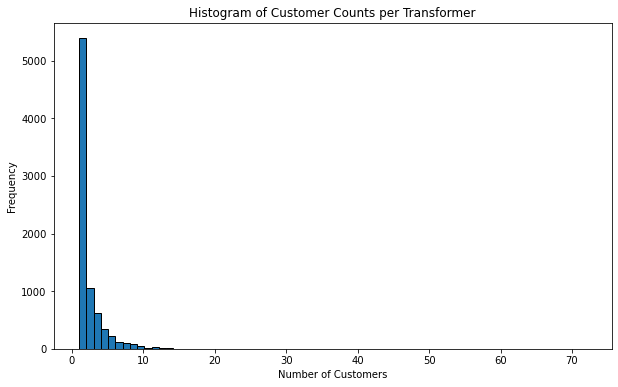

In [19]:
counts = apc.groupby('fldptag')['endpoint_id'].nunique()

# Plot a histogram of these counts
plt.figure(figsize=(10,6))
plt.hist(counts, bins=70, edgecolor='black')
plt.title('Histogram of Customer Counts per Transformer')
plt.xlabel('Number of Customers')
plt.ylabel('Frequency')
plt.show()

As the chart above shows, the overwhelming majority of transformers only serve one customer. These cannot be used in our analysis since they have nothing else in a group to correlate with. Regardless, we need to identify the transformer-customer pairings, and figure out which ones we can use.

### Endpoint-Transformer Pairs
We know that most transformers only serve one customer. What about the ~3k that serve multiple customers? Well, those mostly seem to serve fewer than 10 customers, but we should take a look.

In [20]:
# Create the groupby object that shows us the number of customers per transformer
counts = apc.groupby('fldptag')['endpoint_id'].nunique()

In [21]:
# Create the dataframe from the counts object with a new index
counts_df = counts.reset_index()

In [22]:
# rename the columns
counts_df.columns = ['fldptag', 'unique_customers']

In [23]:
counts_df[counts_df['unique_customers'] >= 10].sort_values('unique_customers', ascending=False)

,fldptag,unique_customers
6733,2002000007674242,72
7525,2002200009696774,38
7725,2002200014576507,21
3267,2002000001841264,21
3283,2002000001841280,20
...,...,...
6788,2002000007787835,10
6790,2002000007787839,10
6798,2002000007787855,10
6800,2002000007787859,10


In [24]:
customer_counts = apc.groupby('fldptag')['endpoint_id'].nunique()

In [25]:
# ten is an arbitrary number here, but for correlations to be effective as a filter
# you need more than just two or three
usable_transformers = customer_counts.loc[customer_counts >10]

In [26]:
usable_transformers.index

Index(['2002000001001784', '2002000001001919', '2002000001054705',
       '2002000001066526', '2002000001067598', '2002000001107783',
       '2002000001107885', '2002000001140046', '2002000001140407',
       '2002000001140412', '2002000001140415', '2002000001140518',
       '2002000001140540', '2002000001301384', '2002000001841254',
       '2002000001841256', '2002000001841258', '2002000001841261',
       '2002000001841262', '2002000001841263', '2002000001841264',
       '2002000001841265', '2002000001841266', '2002000001841274',
       '2002000001841275', '2002000001841276', '2002000001841278',
       '2002000001841279', '2002000001841280', '2002000001841282',
       '2002000002186639', '2002000002186882', '2002000002186899',
       '2002000002276296', '2002000002276314', '2002000002337025',
       '2002000002337116', '2002000002337117', '2002000002337121',
       '2002000002337122', '2002000002337123', '2002000002337124',
       '2002000002337125', '2002000002337126', '20020000023371

### Getting to the Outliers
Knowing that we have a massive data problem (~ half our data is not usable under the approach we've decided on), let's get to work on the data we can use. We're going to get at the correlations and outliers for one transformer, and use that to build out a function that will identify outliers for all of them. Note that we're going for functional before optimal.

NOTE: Cells 1-11 culminate in a cell that takes about an hour to run. It's recommended to avoid those in class.

In [27]:
# # 1) Create a new copy of apc
# outlr = apc.set_index('sample_date')

In [28]:
# # 2) Create a pivot table based on customers
# pvt_outlr = outlr.pivot(columns='endpoint_id', values='voltage')

In [29]:
# # 3) Shape of new pivot table; hugely expanded
# pvt_outlr.shape

In [30]:
# # 4) Pivot tables always create nulls; we need to make sure that we're only using columns with
# # at least a few observations
# pvt_outlr = pvt_outlr.dropna(axis='columns', thresh=35)

In [31]:
# # 5) Lost about 300 columns
# pvt_outlr.shape

In [32]:
# # 6) Or 25% of the data
# pvt_outlr.isna().sum().sum()/(pvt_outlr.shape[0]*pvt_outlr.shape[1])

In [33]:
# 7) Calculate the full correlation matrix; this takes a very, very long time (about 40 minutes)
# %time full_corr = pvt_outlr.corr(min_periods=30)

In [34]:
# 8) Future reference: I stored the whole thing in a csv. It is also huge (~7GB)
# full_corr.to_csv('./data/full_corr.csv')

In [35]:
# 9) Mask the correlation matrix because we only want the entries below the diagonal, 
# exclusive of the diagonal (k=-1)
# masked_full = full_corr.where(np.tril(np.ones(full_corr.shape), k=-1).astype(np.bool_))

In [36]:
# # 10) Calculate stats for the distribution chart below
# full_mean = masked_full.stack().mean()
# full_med = masked_full.stack().median()
# full_std = masked_full.stack().std()

In [37]:
# # 11) Plot the distribution of the correlationsb
# mafig, ax = plt.subplots(figsize =(10, 7))
# ax.hist(masked_full.stack(), bins='auto')
# plt.axvline(full_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {full_mean:.2f}')
# plt.axvline(full_med, color='red', linestyle='dashed', linewidth=2, label=f'Median: {full_med:.2f}') 

# for i in range(1, 4):
#     dev = i * full_std
#     plt.axvline(full_mean - dev, color='green', linestyle='dashed', linewidth=1, 
#                 label=f'Mean - {i} std: {full_mean - dev:.2f}')

# plt.title('Histogram of Correlation Coefficients')
# plt.xlabel('Correlation Coefficient')
# plt.ylabel('Frequency')

# # Add legend
# plt.legend()
    
# # Show plot
# plt.show()

![](./data/full_corr_2.png)

That is the pairwise correlation for every single customer in the dataset with at least 30 non-null datapoints. What we want is the pairwise correlation for every customer currently labeled with a transformer flagged if it is below a certain level of correlation. But we can see that our data are NOT normally distributed. Chebyshev's inequality is probably more useful than anything based on Gaussian normality.

I think it makes sense to go transformer by transformer, so we're going to do it for one transformer then build a function to handle any number of transformers, storing the whole thing as a dictionary. The steps are more or less identical to what we did for the entire transformer-customer dataframe.

### Building a Function for Finding Outliers

In [27]:
# Select one transformer; in this case the one with the most customers labeled with it
build = apc[apc['fldptag']=="2002000007674242"]
# "2002000007674242"

In [28]:
build.head()

,endpoint_id,sample_date,sample_point,voltage,fldptag
76005629,40176904,2023-06-24 12:00:00,1687626000,236.28,2002000007674242
76005630,40176904,2023-06-24 12:15:00,1687626900,236.29,2002000007674242
76005631,40176904,2023-06-24 12:30:00,1687627800,235.72,2002000007674242
76005632,40176904,2023-06-24 12:45:00,1687628700,235.73,2002000007674242
76005633,40176904,2023-06-24 13:00:00,1687629600,237.62,2002000007674242


In [29]:
# We want time to be our index, even though it's not unique to every observation it enables the pivot we need
build = build.set_index('sample_date')

In [30]:
# The pivot gets us each columns voltage at the timestamp
pvt_bld = build.pivot(columns='endpoint_id', values='voltage')

In [31]:
pvt_bld

endpoint_id,40176904,40189148,40579614,40597087,40597341,40602453,40602457,40602746,40602748,40602752,...,40668765,40668984,40669005,40669049,40669402,40669511,40669580,40670591,40670623,40671075
sample_date,,,,,,,,,,,,,,,,,,,,,
2023-06-24 12:00:00,236.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-24 12:15:00,236.29,236.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-24 12:30:00,235.72,236.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-24 12:45:00,235.73,235.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-24 13:00:00,237.62,237.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 15:00:00,236.80,236.43,236.68,236.73,236.60,236.19,236.40,236.03,236.77,236.26,...,236.54,236.47,236.77,237.22,236.96,236.68,236.68,236.15,236.84,NaN
2023-06-27 15:15:00,236.37,236.18,236.17,235.94,236.10,236.19,236.08,235.59,236.41,235.76,...,236.36,236.50,236.22,236.69,236.03,236.57,235.98,236.18,236.22,236.08
2023-06-27 15:30:00,237.40,237.54,237.77,237.27,237.03,237.47,237.65,237.53,238.14,238.02,...,237.25,237.65,237.70,237.73,237.48,237.93,237.46,237.51,237.23,236.95


In [32]:
pvt_bld.isnull().sum().sort_values(ascending=False)

endpoint_id
40671075    301
40670591    299
40670623    299
40669580    296
40669511    295
           ... 
40602453     20
40597341     19
40597087     19
40189148      1
40176904      0
Length: 72, dtype: int64

It's pretty common for pivots to create a lot of null values. In general, we want at least 30 observations for the Central Limit Theorem to work its magic, but we are always limited by the data we have.

In [33]:
# this gets us the pairwise Pearson correlation coefficients for every timeseries in the dataframe
pvtd_corr = pvt_bld.corr()

In [34]:
pvtd_corr

endpoint_id,40176904,40189148,40579614,40597087,40597341,40602453,40602457,40602746,40602748,40602752,...,40668765,40668984,40669005,40669049,40669402,40669511,40669580,40670591,40670623,40671075
endpoint_id,,,,,,,,,,,,,,,,,,,,,
40176904,1.000000,0.980153,0.920611,0.979491,0.982535,0.983401,0.980964,0.979313,0.976677,0.977946,...,0.910972,0.877252,0.803282,0.883993,0.977256,0.936916,0.926014,0.962601,0.982519,0.984424
40189148,0.980153,1.000000,0.932455,0.977646,0.980225,0.976851,0.983684,0.976527,0.976064,0.978996,...,0.853660,0.895764,0.886802,0.745408,0.977351,0.906832,0.983575,0.989116,0.981999,0.989485
40579614,0.920611,0.932455,1.000000,0.932216,0.929941,0.933720,0.925526,0.943946,0.956282,0.952309,...,0.844814,0.961072,0.857522,0.898179,0.933207,0.942434,0.806511,0.961020,0.930179,0.954259
40597087,0.979491,0.977646,0.932216,1.000000,0.982520,0.976290,0.977499,0.981768,0.979193,0.979794,...,0.886496,0.850736,0.738059,0.937200,0.976940,0.934275,0.869165,0.940333,0.944293,0.981460
40597341,0.982535,0.980225,0.929941,0.982520,1.000000,0.981940,0.981288,0.979615,0.979051,0.981820,...,0.913462,0.936337,0.892046,0.844690,0.979189,0.930206,0.952603,0.968614,0.997385,0.997683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40669511,0.936916,0.906832,0.942434,0.934275,0.930206,0.967593,0.848461,0.956002,0.941762,0.935073,...,0.931398,0.968219,0.849018,0.934507,0.938834,1.000000,0.878564,0.992772,0.948625,0.965098
40669580,0.926014,0.983575,0.806511,0.869165,0.952603,0.911820,0.942957,0.840427,0.792056,0.873260,...,0.905212,0.850383,0.921091,0.837453,0.962456,0.878564,1.000000,0.981173,0.992313,0.988984
40670591,0.962601,0.989116,0.961020,0.940333,0.968614,0.994129,0.976294,0.950007,0.935308,0.970525,...,0.957990,0.979112,0.973969,0.959611,0.957051,0.992772,0.981173,1.000000,0.968119,0.987966


In [46]:
# tril_indices = np.tril_indices_from(pvtd_corr, k=-1)

In [47]:
# tril_indices

In [48]:
# corr_values = pvtd_corr.values[tril_indices]

In [49]:
# corr_values

In [50]:
# But we only need the lower half of them - the ones below the diagonal of ones
# lower_triangle = pvtd_corr.where(np.tril(np.ones(pvtd_corr.shape), k=-1).astype(np.bool_))

In [35]:
# Since we want to detect outliers automatically, we need to see the distribution.
# Everythign above the diagonal is going to double up our data, so we just want below the diagonal
masked = pvtd_corr.mask(np.triu(np.ones(pvtd_corr.shape, dtype=np.bool_)))

In [36]:
masked

endpoint_id,40176904,40189148,40579614,40597087,40597341,40602453,40602457,40602746,40602748,40602752,...,40668765,40668984,40669005,40669049,40669402,40669511,40669580,40670591,40670623,40671075
endpoint_id,,,,,,,,,,,,,,,,,,,,,
40176904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40189148,0.980153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40579614,0.920611,0.932455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40597087,0.979491,0.977646,0.932216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40597341,0.982535,0.980225,0.929941,0.982520,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40669511,0.936916,0.906832,0.942434,0.934275,0.930206,0.967593,0.848461,0.956002,0.941762,0.935073,...,0.931398,0.968219,0.849018,0.934507,0.938834,NaN,NaN,NaN,NaN,NaN
40669580,0.926014,0.983575,0.806511,0.869165,0.952603,0.911820,0.942957,0.840427,0.792056,0.873260,...,0.905212,0.850383,0.921091,0.837453,0.962456,0.878564,NaN,NaN,NaN,NaN
40670591,0.962601,0.989116,0.961020,0.940333,0.968614,0.994129,0.976294,0.950007,0.935308,0.970525,...,0.957990,0.979112,0.973969,0.959611,0.957051,0.992772,0.981173,NaN,NaN,NaN


In [37]:
# Stacking means turning the whole df into a large array
corr_mean = masked.stack().mean()

corr_std = masked.stack().std()

corr_med = masked.stack().median()

In [38]:
masked[40189148].mean()

0.9486872900012882

In [39]:
corr_mean - (corr_std * 2)

0.8338313393247552

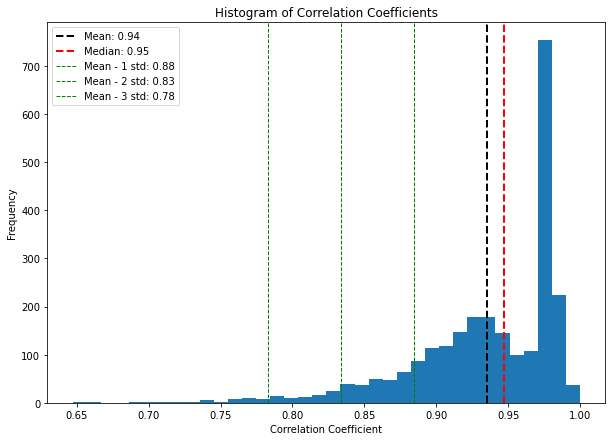

In [48]:
# Plot to see the distribution; not strictly necessary but we should always take a look at our data when we can
mafig, ax = plt.subplots(figsize =(10, 7))
ax.hist(masked.stack(), bins='auto')
plt.axvline(corr_mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {corr_mean:.2f}')
plt.axvline(corr_med, color='red', linestyle='dashed', linewidth=2, label=f'Median: {corr_med:.2f}') 

for i in range(1, 4):
    dev = i * corr_std
    plt.axvline(corr_mean - dev, color='green', linestyle='dashed', linewidth=1, 
                label=f'Mean - {i} std: {corr_mean - dev:.2f}')

plt.title('Histogram of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')

# Add legend
plt.legend()
    
# Show plot
plt.show()

In [41]:
# flagged_correlations = masked < (corr_mean - (2 * corr_std))

In [42]:
column_means = masked.mean()

In [43]:
flagged_correlations = column_means[column_means < (corr_mean - (1 * corr_std))].index

In [44]:
def identify_outliers(transformer, std_threshold=1, null_threshold=35):
    """A function to identify customer whose voltmeter correlation coefficients are `threshold` standard
    deviations below the mean of all the coefficients associated with that transformer. Assumes the apc dataframe
    with columns 'endpoint_id', 'sample_date', 'sample_point', 'voltage', and 'fldptag'. Assumes 'sample_date' is 
    datetime object.
    
    Parameters
    ----------
    transformer - str; the id of a transformer; assumed to be 'fldptag'
    std_threshold - int; the number of standard deviations used to identify mislabeled pairings
    null_threshold - int; defaultl 35; non-null threshold
    
    Returns
    ----------
    result - a dictionary whose key is `transformer` and whose value is a list of the flagged customers
    """
    # Filter the correct fldptag
    working = apc[apc['fldptag'] == transformer]
#     print(working)
    
    # Reset the index to datetime for the pivot
    working = working.set_index('sample_date')
#     print(working)
    
    # Create the pivot table using endpoint_id as column, voltage as values
    working = working.pivot(columns='endpoint_id', values='voltage')
#     print(working)
    
    # Drop nulls to slightly improve our correlations
    working = working.dropna(axis='columns', thresh=null_threshold)
    
    # Calculate the correlation matrix off the pivot table
    corr_matrix = working.corr()
#     print(corr_matrix)
    
    # Get values from below the diagonal, as an array for easy storage, calculation
    masked = corr_matrix.mask(np.triu(np.ones(corr_matrix.shape, dtype=np.bool_)))
#     print(masked)
    
    # Calculate the mean and standard deviation
    corr_mean = masked.stack().mean()
#     print(corr_mean)
    corr_std = masked.stack().std()
#     print(corr_std)
    column_means = masked.mean()
#     print("columns means: ", column_means)
    thresh_calc = std_threshold * corr_std
    
    # Apply the threshold to the correlation values
    flagged_correlations = column_means[column_means < (corr_mean - thresh_calc)].index
#     print(flagged_correlations)
    
    # Get the IDs
    flagged_customer_ids = list(flagged_correlations)
#     print(flagged_customer_ids)
    output = {
        'mean': corr_mean,
        'std': corr_std,
        'count_flagged':len(flagged_customer_ids),
        'flagged_ids': flagged_customer_ids
    }
#     print(output)
    return output
    
    

In [45]:
identify_outliers("2002000007674242", std_threshold=1, null_threshold=35)

{'mean': 0.9498551328489139,
 'std': 0.03561714109119065,
 'count_flagged': 6,
 'flagged_ids': [40606605, 40609464, 40612395, 40615773, 40616019, 40617858]}

From here, we can wrap the function in a loop and produce a dictionary containing all the transformers with outliers.

In [46]:
%%timeit
outlier_candidates = {}

for i in usable_transformers.index:
    outlier_candidates[i] = identify_outliers(i, 1, 35)

8min 40s ± 39.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
outlier_candidates

{'2002000001001784': {'mean': 0.9633160401632174,
  'std': 0.006765002281952789,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000001001919': {'mean': 0.9437384817002462,
  'std': 0.03823091739844537,
  'count_flagged': 1,
  'flagged_ids': [40692638]},
 '2002000001054705': {'mean': 0.9758579074576119,
  'std': 0.01723271352687789,
  'count_flagged': 1,
  'flagged_ids': [43126810]},
 '2002000001066526': {'mean': 0.9548179092834795,
  'std': 0.018124269396123514,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000001067598': {'mean': 0.9752431197227684,
  'std': 0.0078956515116379,
  'count_flagged': 1,
  'flagged_ids': [40610079]},
 '2002000001107783': {'mean': 0.947933462168207,
  'std': 0.04477608800330263,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000001107885': {'mean': 0.9638174881022508,
  'std': 0.012457660093524156,
  'count_flagged': 0,
  'flagged_ids': []},
 '2002000001140046': {'mean': 0.9406972506062825,
  'std': 0.02782527862089762,
  'count_flagged': 2,
  'fl

### Sources
[1] Blakely, Logan. 2021. "Identification and Correction of Errors in Pairing AMI Meters and Transformers." United States. https://doi.org/10.2172/1860605. https://www.osti.gov/servlets/purl/1860605.